In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import pickle

# Step 1: Data Preprocessing
# Load dataset
file_path = "Titanic-Dataset.csv"  # Update if necessary
df = pd.read_csv(file_path)

In [33]:
# Display basic info
print(df.head())
print(df.info())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [34]:
# Handle missing values
imputer_numeric = SimpleImputer(strategy="most_frequent")
df["Age"] = imputer_numeric.fit_transform(df[["Age"]])
df["Fare"] = imputer_numeric.fit_transform(df[["Fare"]])  # In case Fare has missing values

imputer_categorical = SimpleImputer(strategy="most_frequent")
df["Embarked"] = pd.Series(imputer_categorical.fit_transform(df[["Embarked"]]).ravel(), index=df.index)

In [35]:
# Drop columns not useful for prediction
df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)

# Encode categorical variables
df["Sex"] = LabelEncoder().fit_transform(df["Sex"])  # Male = 1, Female = 0
df = pd.get_dummies(df, columns=["Embarked"], drop_first=True)  # One-hot encoding for "Embarked"


In [36]:
# Normalize numerical features
scaler = StandardScaler()
df[["Age", "Fare"]] = scaler.fit_transform(df[["Age", "Fare"]])

In [37]:
# Split dataset (70% train, 15% validation, 15% test)
X = df.drop("Survived", axis=1)
y = df["Survived"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [38]:
# Step 2: Model Building
# Initialize model
model = LogisticRegression()

# Hyperparameter tuning using GridSearchCV
param_grid = {"C": [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='accuracy')

In [39]:
# Train best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)


LogisticRegression(C=0.1)

In [40]:
# Step 3: Model Evaluation
y_pred = best_model.predict(X_test)


In [41]:
# Classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Accuracy: 0.7537
Precision: 0.6875
Recall: 0.6471
F1 Score: 0.6667
ROC-AUC Score: 0.7980


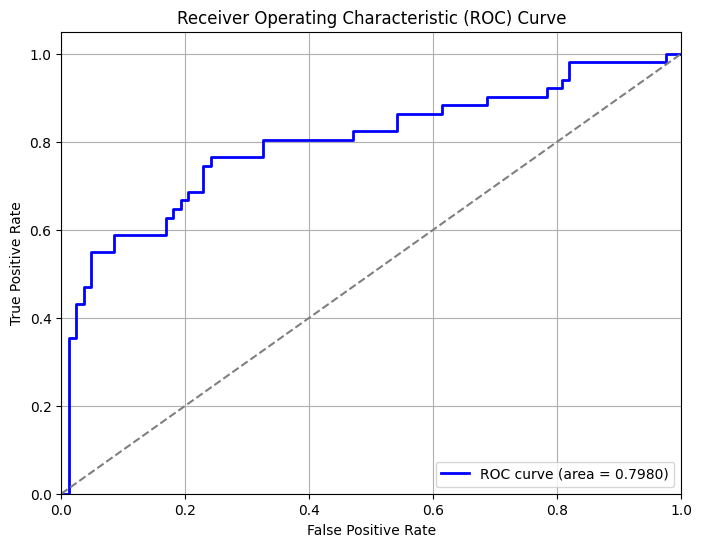

In [42]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="grey", linestyle="--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

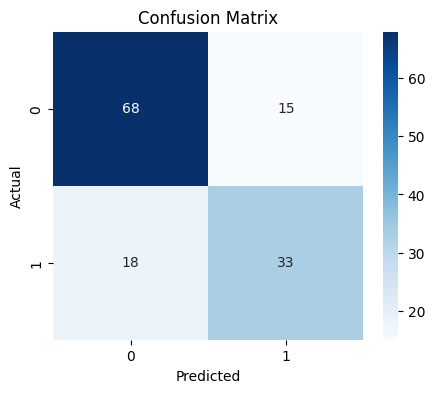

In [43]:
# Confusion Matrix Visualization
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [44]:
# Step 4: Model Deployment
model_filename = "titanic_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(best_model, file)

print(f"Model saved as {model_filename}")

Model saved as titanic_model.pkl
